# Vanilla models test

- Artificial Neural Networks
- Decision Tree Classifier
- Random Forest
- Gradient Boosting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4321143392220899876
xla_global_id: -1
]


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

## Dataset loading

In [4]:
train = pd.read_csv("data/train.csv")
valid = pd.read_csv("data/valid.csv")
test  = pd.read_csv("data/test.csv")

Reducing the data

In [5]:
def random_n_images(df,no_imgs=10000,shuffle=False):
    each_label_images = int(no_imgs / 2)
    subset_label_0 = df[df['label'] == 0].sample(n=each_label_images, random_state=69)
    subset_label_1 = df[df['label'] == 1].sample(n=each_label_images, random_state=69)
    final_subset = pd.concat([subset_label_0, subset_label_1]) 
    if shuffle == True:
        final_subset = final_subset.sample(frac=1, random_state=69).reset_index(drop=True)
    return final_subset

train_subset = random_n_images(train,no_imgs=10000,shuffle=True)
valid_subset = random_n_images(valid,no_imgs=2000,shuffle=False)
test_subset = random_n_images(test,no_imgs=2000,shuffle=False)

Converting to tensors

In [6]:
BATCH_SIZE = 32
image_height = 256
image_width = 256

In [7]:
train_tfds = tf.data.Dataset.from_tensor_slices((train_subset['path'].values,train_subset['label'].values))
valid_tfds = tf.data.Dataset.from_tensor_slices((valid_subset['path'].values,valid_subset['label'].values))
test_tfds = tf.data.Dataset.from_tensor_slices((test_subset['path'].values,test_subset['label'].values))

def read_image(image_file, label):
    image = tf.io.read_file("data/real_vs_fake/real-vs-fake/" + image_file)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def augument(image, label):
    return image, label

train_tfds = train_tfds.map(read_image).map(augument).batch(BATCH_SIZE)
valid_tfds = valid_tfds.map(read_image).map(augument).batch(1).prefetch(1)
test_tfds = test_tfds.map(read_image).map(augument).batch(1)

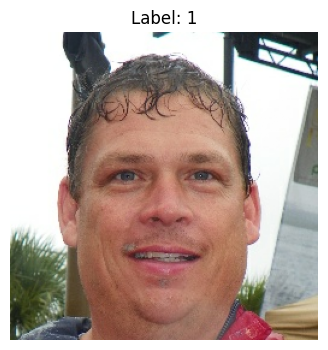

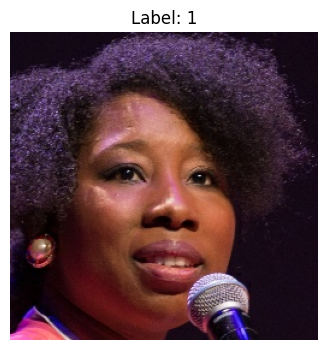

In [8]:
for images, labels in train_tfds.take(1):  # Adjust the number of batches as needed
    for i in range(2):
        plt.figure(figsize=(4, 4))
        plt.imshow(images[i, :, :, :].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
        plt.show()

## Convolutional neural network

In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation="sigmoid")(x)

resnet_clf = Model(inputs=base_model.input, outputs=predictions)

In [14]:
save_callback = ModelCheckpoint('/models/model_checkpoint_{epoch:02d}_{val_accuracy:.2f}.h5'
                                ,save_weights_only=False
                                ,monitor='val_accuracy'
                                ,save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss'
                                        ,patience=5)

resnet_clf.compile(optimizer=Adam()
                   ,loss='binary_crossentropy'
                   ,metrics=['accuracy'])
# resnet_clf.summary()

In [ ]:
tf.keras.backend.clear_session()
resnet_clf_history = resnet_clf.fit(
    train_tfds,
    epochs=100,
    validation_data=valid_tfds,
    callbacks=[save_callback, early_stopping_callback],
    use_multiprocessing=True
)

In [ ]:
# Visualizing results
training_loss = resnet_clf_history.history['loss']
validation_loss = resnet_clf_history.history['val_loss']
training_accuracy = resnet_clf_history.history['accuracy']
validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Testing set
resnet_clf.evaluate(test_tfds)

In [ ]:
# Saving model
from datetime import datetime
filename = f'models/resnet_clf_{datetime.now().timestamp()}.h5'
tf.keras.models.save_model(resnet_clf, filename)

Manual testing

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [ ]:
# Real image
img_path = "manual_test_images/Real.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

In [ ]:
# Fake image(hard)
img_path = "manual_test_images/Hard.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

In [ ]:
# Fake image(hard)
img_path = "manual_test_images/Hard.jpeg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

In [ ]:
# Fake image(easy)
img_path = "manual_test_images/Easy.jpg"
img = image.load_img(img_path, target_size=(256, 256))
plt.imshow(img)
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array.reshape(1, 256, 256, 3))

# Assuming resnet_clf_history is your ResNet model
prediction = resnet_clf.predict(img_array)

# Process the prediction as needed
print(prediction)

## Loading the best model so far

In [13]:
from tensorflow.keras.models import load_model
model = load_model("models/resnet_clf_1703610668.109097.h5")
model.evaluate(test_tfds)

2000/2000 [==============================] - 152s 76ms/step - loss: 0.2050 - accuracy: 0.9250


[0.20501020550727844, 0.925000011920929]

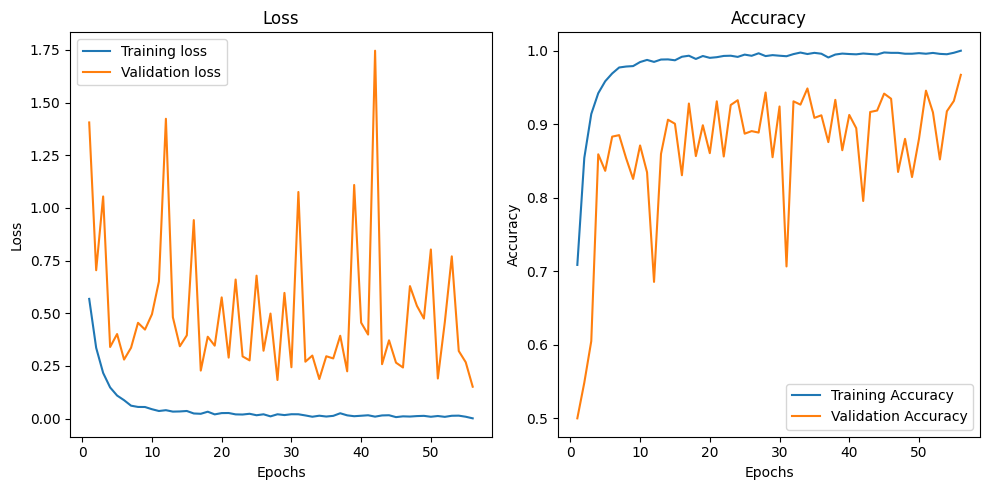

In [12]:
# Visualizing results
# training_loss = resnet_clf_history.history['loss']
# validation_loss = resnet_clf_history.history['val_loss']
# training_accuracy = resnet_clf_history.history['accuracy']
# validation_accuracy = resnet_clf_history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting Loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training loss')
plt.plot(epochs, validation_loss, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()